In [1]:
%pip install numpy
%pip install keras
%pip install matplotlib
%pip install tensorflow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

In [3]:
df = pd.read_csv("./wildfire_dataset.csv")
df

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
0,2021,HWF053,NaN,5.50,C,59.522139,-119.926971,Provincial Land,Lightning,NaN,...,NaN,NaN,6/28/21 22:26,0.01,7/1/21 13:26,10.00,NaN,NaN,7/1/21 13:44,5.50
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,4/9/21 8:30,0.01
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,4/17/21 14:15,0.10
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,4/17/21 15:24,0.01
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,4/12/21 14:30,7.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,CWF231,NaN,0.10,A,51.161883,-114.869317,Indian Reservation,Resident,NaN,...,NaN,NaN,3/11/07 17:35,0.01,3/11/07 17:45,0.01,NaN,NaN,3/11/07 18:00,0.10
22910,2006,CWF232,NaN,0.01,A,51.084150,-115.392633,Provincial Park,Undetermined,NaN,...,NaN,NaN,3/19/07 10:25,0.01,3/19/07 10:25,0.01,NaN,NaN,3/19/07 10:40,0.01
22911,2006,CWF233,NaN,0.70,B,51.333900,-114.997667,Provincial Land,Recreation,NaN,...,NaN,NaN,3/26/07 2:00,0.70,3/26/07 2:00,0.70,NaN,NaN,3/26/07 12:00,0.70
22912,2006,CWF234,NaN,0.01,A,51.071467,-115.316300,Provincial Land,Resident,NaN,...,NaN,NaN,3/28/07 11:00,0.01,3/28/07 11:00,0.01,NaN,NaN,3/28/07 11:30,0.01


Dictionaries:

In [4]:
FSA_dict = {'C': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'E': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'H': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'G': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'L': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'M': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'P': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'R': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'S': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'W': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]}

causes_dict =  {'C': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'E': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'H': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'G': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'L': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'M': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'P': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'R': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'S': {'general_c': 0, 'activity_c': 0, 'true_c': 0}, 
                'W': {'general_c': 0, 'activity_c': 0, 'true_c': 0}}

Initialize the Causes Dictionary

In [5]:
g_causes = {}
a_causes = {}
t_causes = {}

for index in df.index:
    general = df.loc[index, 'general_cause_desc']
    activity = df.loc[index, 'activity_class']
    true_c = df.loc[index, 'true_cause']

    if (general not in g_causes):
        g_causes[general] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (activity not in a_causes):
        a_causes[activity] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]
    if (true_c not in t_causes):
        
        t_causes[true_c] = [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]

for key, value in causes_dict.items():
    causes_dict[key]['general_c'] = copy.deepcopy(g_causes)
    causes_dict[key]['activity_c'] = copy.deepcopy(a_causes)
    causes_dict[key]['true_c'] = copy.deepcopy(t_causes)

Fill the Dictionaries

In [6]:
weighted_FSA = {'C': 0, 'E': 0, 'H': 0, 'G': 0, 'L': 0, 'M': 0, 'P': 0, 'R': 0, 'S': 0, 'W': 0}

for index in df.index: 

    region = df.loc[index, 'fire_number']
    region = region[:1]
    FSA_dict[region][0] +=1
    classtemp = df.loc[index, 'size_class']
    FSA_dict[region][1][classtemp] += 1
    size = df.loc[index, 'current_size']
    weighted_FSA[region] += size

    general = df.loc[index, 'general_cause_desc']
    causes_dict[region]['general_c'][general][0] += 1
    causes_dict[region]['general_c'][general][1][classtemp] += 1
    activity = df.loc[index, 'activity_class']
    causes_dict[region]['activity_c'][activity][0] += 1
    causes_dict[region]['activity_c'][activity][1][classtemp] += 1
    true_c = df.loc[index, 'true_cause']
    causes_dict[region]['true_c'][true_c][0] += 1
    causes_dict[region]['true_c'][true_c][1][classtemp] += 1

In [28]:
g_causes_list = list(g_causes.keys())
a_causes_list = list(a_causes.keys())
t_causes_list = list(t_causes.keys())
ge = {}
ac = {}
tr = {}

for index in range(len(g_causes_list)):
    ge[g_causes_list[index]] = 0
for index in range(len(a_causes_list)):
    ac[a_causes_list[index]] = 0
for index in range(len(t_causes_list)):
    tr[t_causes_list[index]] = 0

size_general_dict = {'A': ge, 'B': ge, 'C': ge, 'D': ge, 'E': ge}
size_activity_dict = {'A': ac, 'B': ac, 'C': ac, 'D': ac, 'E': ac}
size_true_dict = {'A': tr, 'B': tr, 'C': tr, 'D': tr, 'E': tr}

size_general_dict = {key: copy.deepcopy(ge) for key, value in size_general_dict.items()}
size_activity_dict = {key: copy.deepcopy(ac) for key, value in size_activity_dict.items()}
size_true_dict = {key: copy.deepcopy(tr) for key, value in size_true_dict.items()}


for key,value in causes_dict.items():
    for l,t in value['general_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_general_dict[k][l] += v
    
    for l,t in value['activity_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_activity_dict[k][l] += v
    for l,t in value['true_c'].items():
        temp = 0
        for k,v in t[1].items():
            size_true_dict[k][l] += v

for key, value in size_activity_dict.items():
    size_activity_dict[key].pop(np.nan)

for key, value in size_true_dict.items():
    size_true_dict[key].pop(np.nan)

print(size_general_dict)
print(size_activity_dict)
print(size_true_dict)


{'A': {'Lightning': 4398, 'Forest Industry': 303, 'Incendiary': 1082, 'Resident': 2661, 'Recreation': 4837, 'Agriculture Industry': 288, 'Government': 69, 'Power Line Industry': 751, 'Oil & Gas Industry': 254, 'Undetermined': 439, 'Railroad': 56, 'Other Industry': 211, 'Under Investigation': 0, 'Prescribed Fire': 10, 'Restart': 43}, 'B': {'Lightning': 2467, 'Forest Industry': 93, 'Incendiary': 792, 'Resident': 1081, 'Recreation': 318, 'Agriculture Industry': 159, 'Government': 39, 'Power Line Industry': 351, 'Oil & Gas Industry': 130, 'Undetermined': 239, 'Railroad': 61, 'Other Industry': 72, 'Under Investigation': 0, 'Prescribed Fire': 6, 'Restart': 17}, 'C': {'Lightning': 564, 'Forest Industry': 14, 'Incendiary': 89, 'Resident': 172, 'Recreation': 58, 'Agriculture Industry': 39, 'Government': 3, 'Power Line Industry': 44, 'Oil & Gas Industry': 12, 'Undetermined': 45, 'Railroad': 8, 'Other Industry': 8, 'Under Investigation': 0, 'Prescribed Fire': 1, 'Restart': 3}, 'D': {'Lightning': 

In [98]:
def draw_stacked(size_dict):
    categories = list(size_dict['A'].keys())
    subcategories = list(size_dict.keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    for category in categories:
        values = [size_dict[subcategory][category] for subcategory in subcategories]
        ax.bar(subcategories, values, label=category)

    ax.set_xlabel('Size Classes')
    ax.set_ylabel('Number of Fires')
    ax.set_title('Number of Fires by Causes in relation to Different Size Classes')
    ax.legend(title='Causes', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



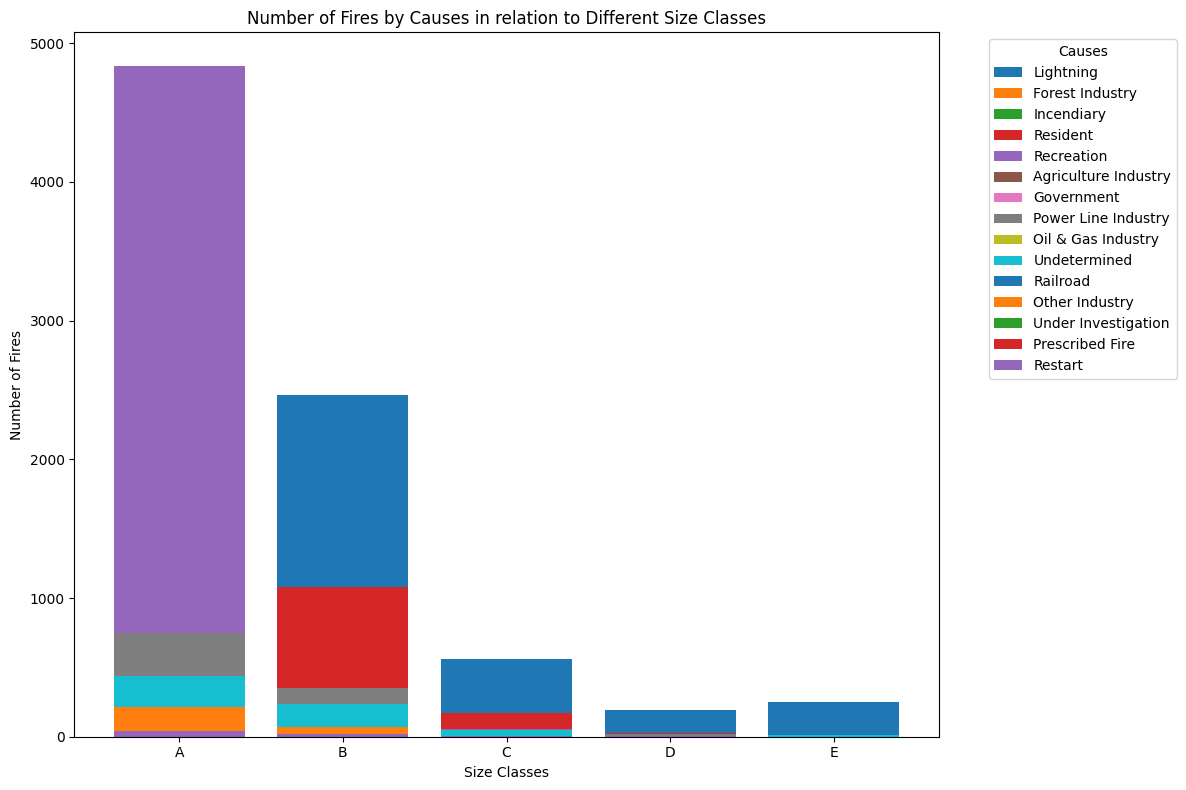

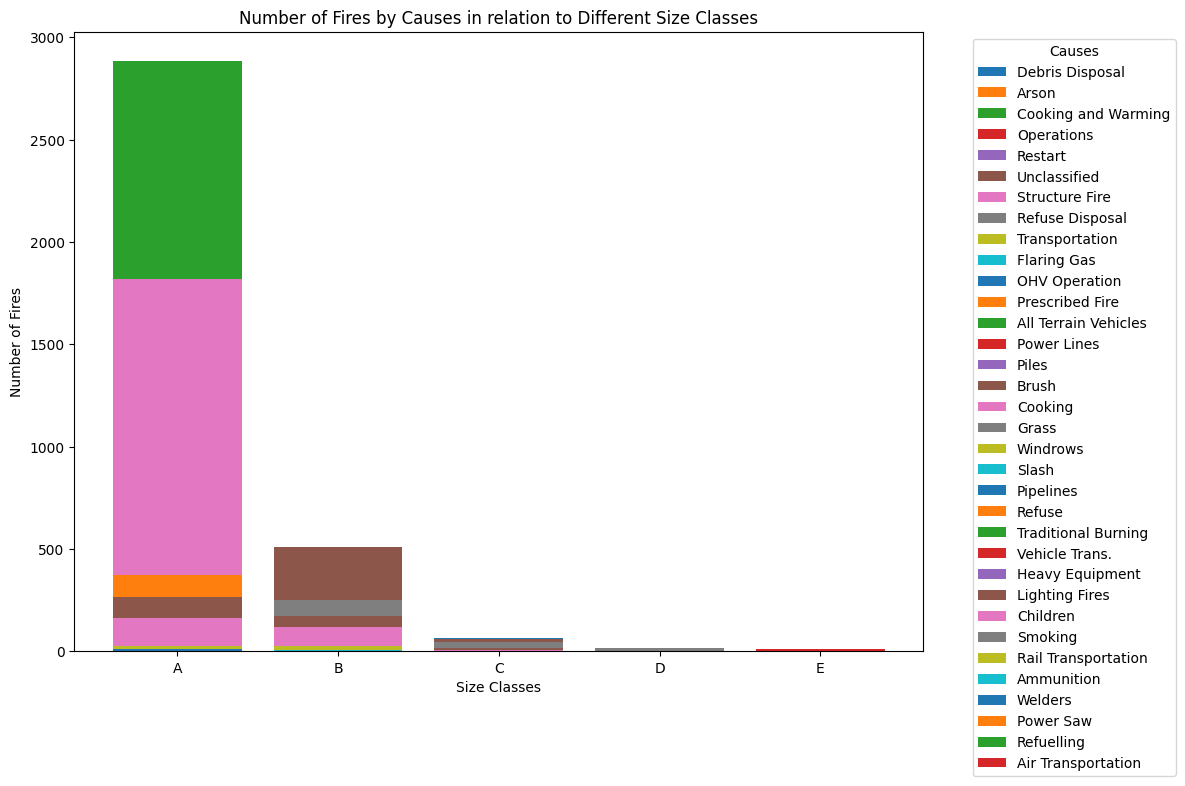

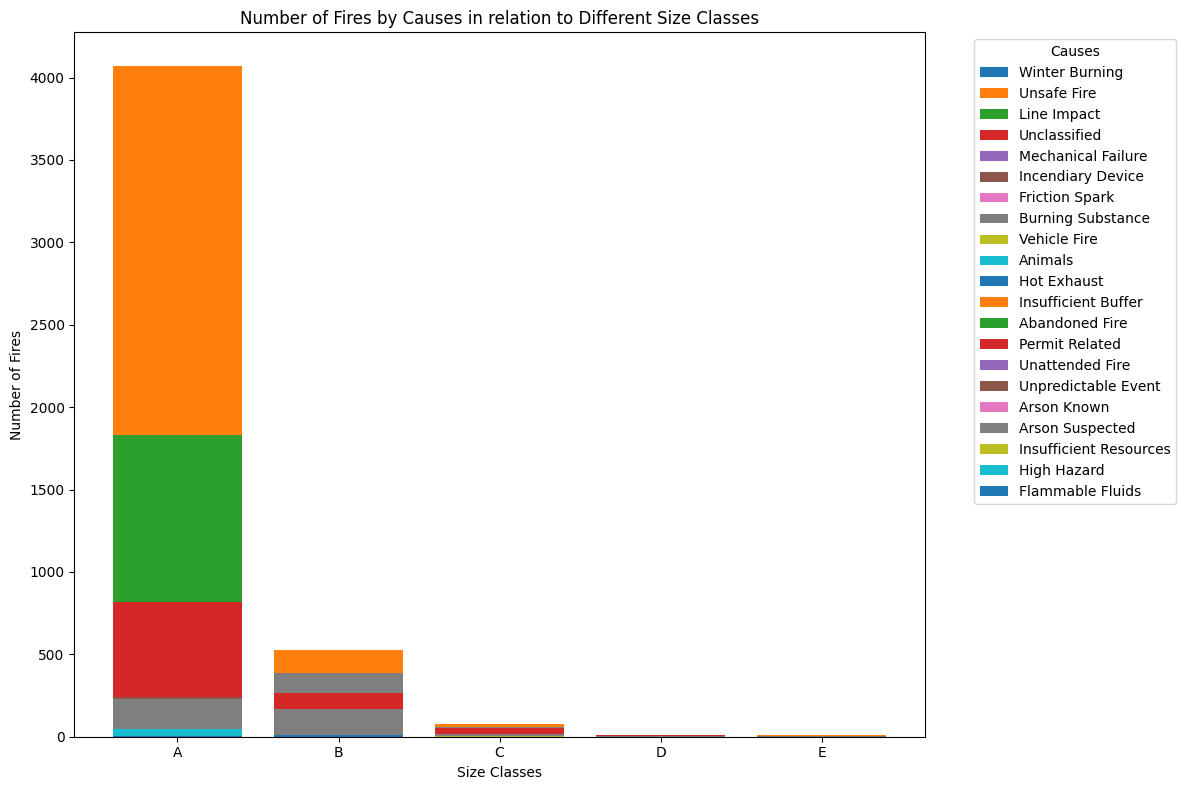

In [99]:
draw_stacked(size_general_dict)
draw_stacked(size_activity_dict)
draw_stacked(size_true_dict)

In [31]:
g_causes_total = {}
a_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['general_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    g_causes_total[key] = temp

a_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['activity_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    a_causes_total[key] = temp


t_causes_total = {}
for key,value in causes_dict.items():
    temp = {}
    for k,v in value['true_c'].items():
        try:
            temp[k] = v[0]
        except(KeyError):
            break
    t_causes_total[key] = temp

for key, value in a_causes_total.items():
    a_causes_total[key].pop(np.nan)

for key, value in t_causes_total.items():
    t_causes_total[key].pop(np.nan)

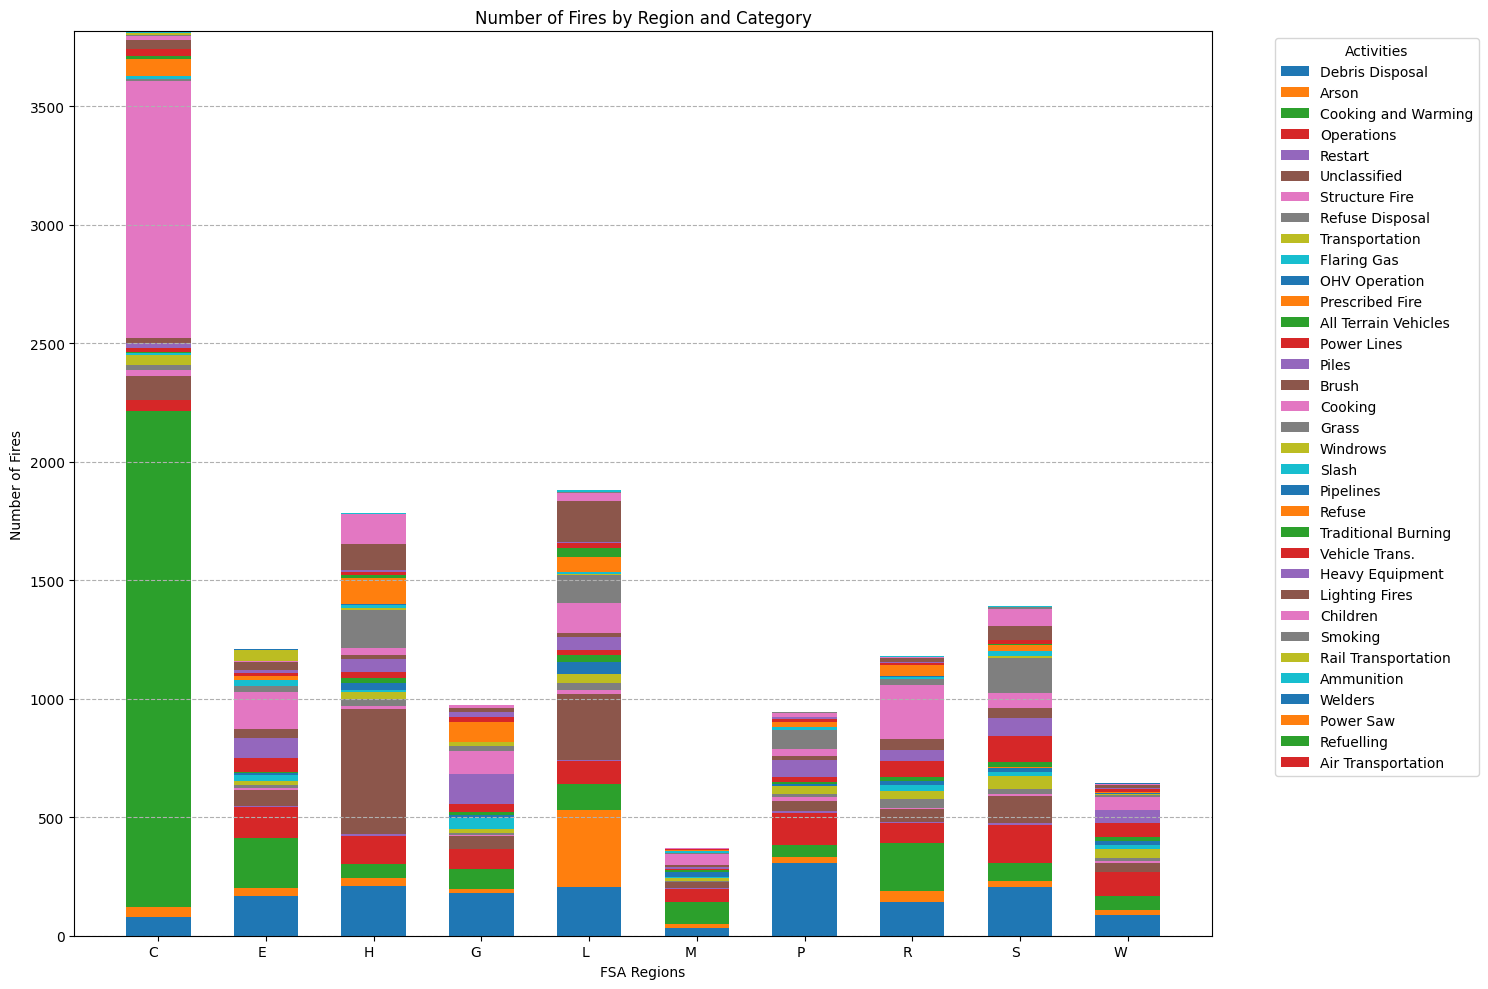

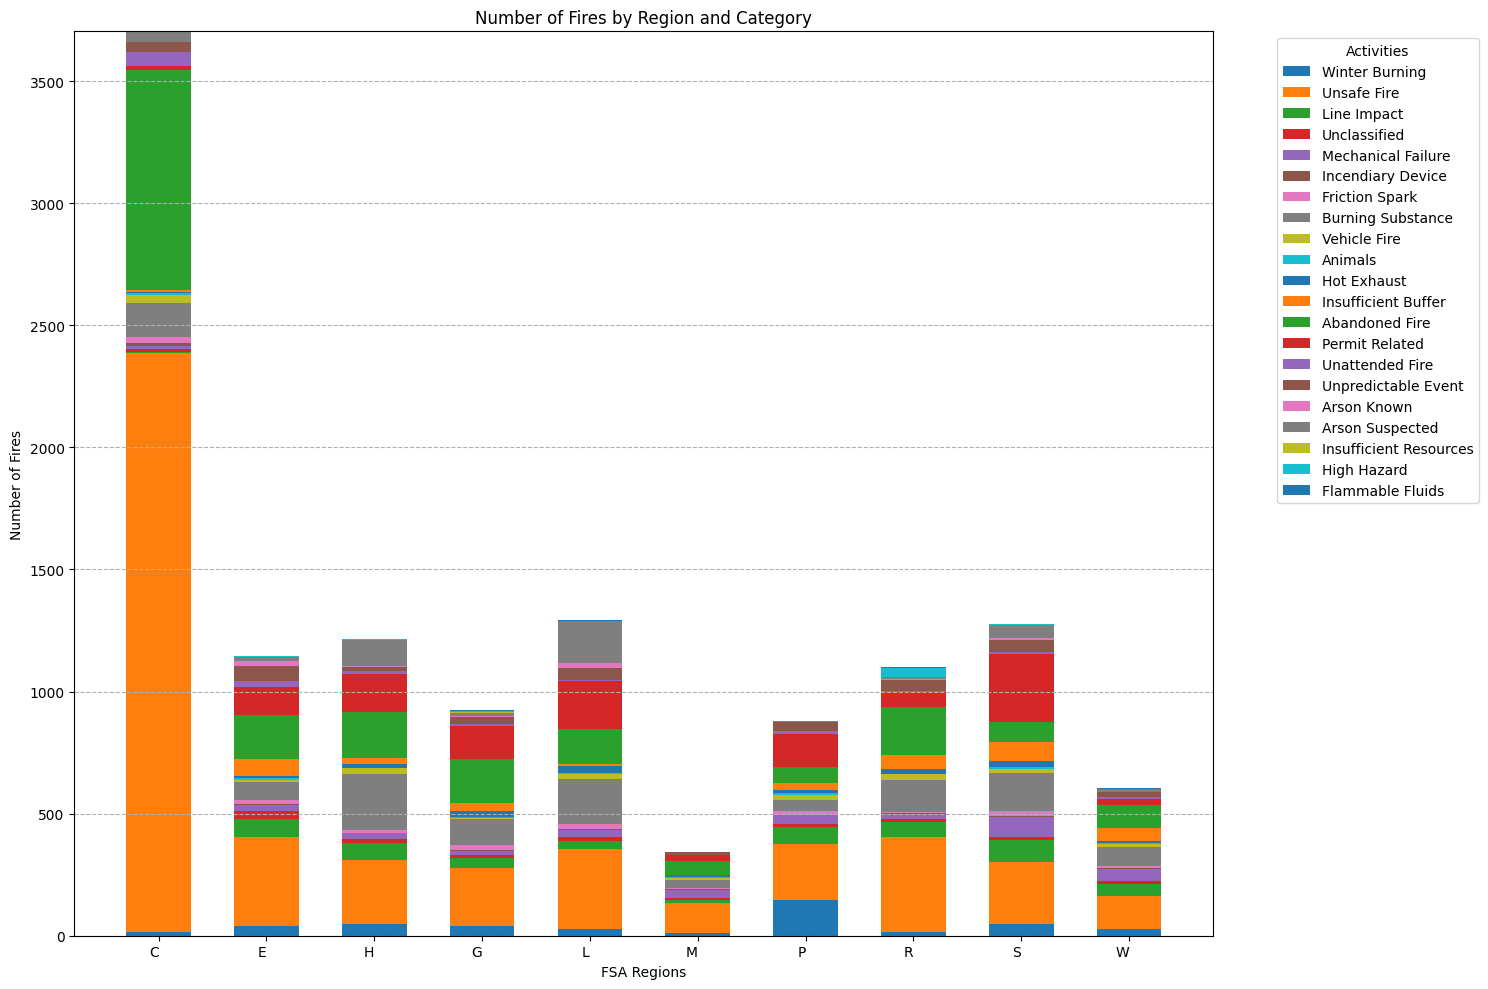

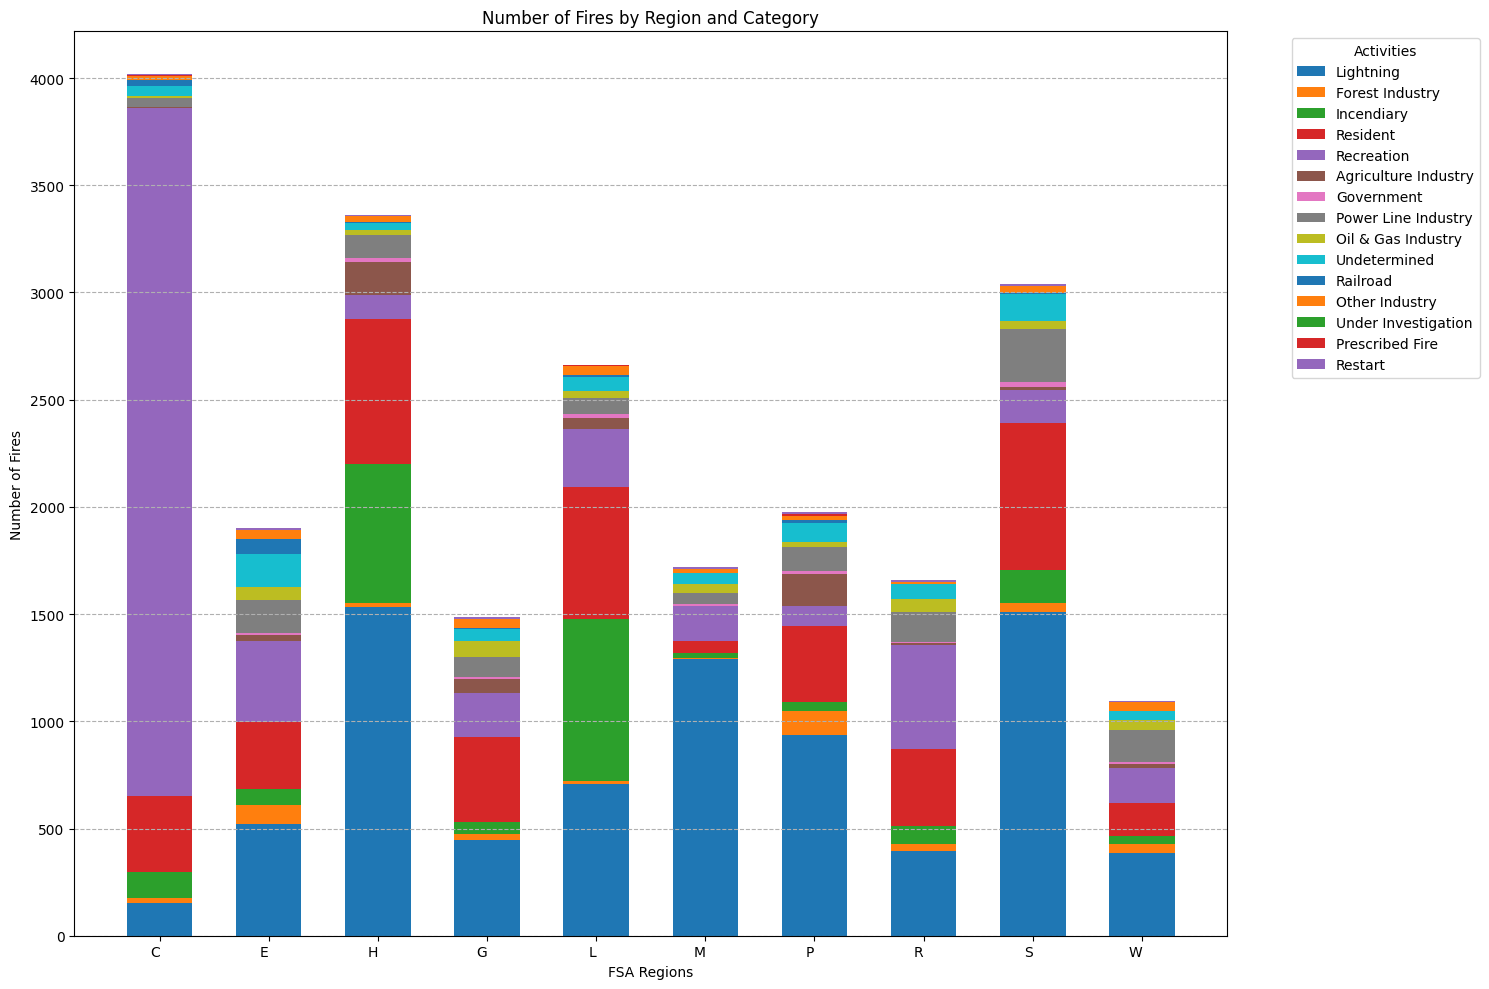

In [129]:
def plot_fires_by_region_and_category(causes_total):
    categories = list(causes_total['C'].keys())
    labels = list(causes_total.keys())

    fig, ax = plt.subplots(figsize=(15, 10))
    bar_width = 0.6

    for i, category in enumerate(categories):
        values = [causes_total[label][category] for label in labels]
        bottom_values = [sum(causes_total[label][categories[j]] for j in range(i)) for label in labels]

        ax.bar(labels, values, width=bar_width, label=category, bottom=bottom_values)

    ax.set_ylabel('Number of Fires')
    ax.set_xlabel('FSA Regions')
    ax.set_title('Number of Fires by Region and Category')
    ax.legend(title='Activities', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--')
    plt.show()


plot_fires_by_region_and_category(a_causes_total)

plot_fires_by_region_and_category(t_causes_total)

plot_fires_by_region_and_category(g_causes_total)

4017
1901
3362
1486
2663
1719
1975
1657
3039
1095
[1.252213094349205, 22.034139926354126, 327.3264069006595, 4.955248990578835, 35.49276380022435, 954.0115590459619, 49.66469873417669, 10.963379601689496, 176.0353109575535, 11.525105022831127]


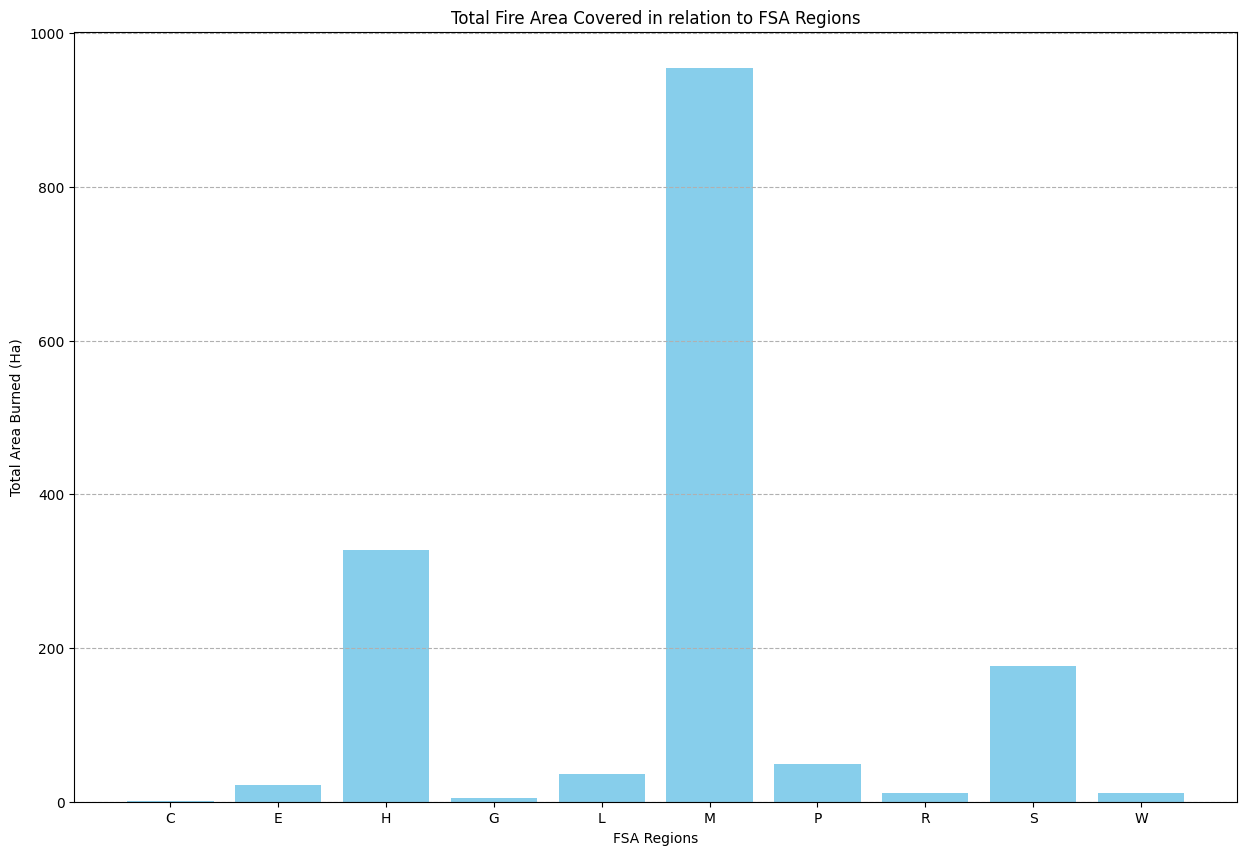

In [130]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

for index in range(len(values)):

    total = list(FSA_dict.values())[index]
    values[index] = values[index]/total[0]
    print(total[0])

print(values)
plt.figure(figsize=(15, 10))
plt.bar(categories, values, color='skyblue')
plt.title('Total Fire Area Covered in relation to FSA Regions')
plt.xlabel('FSA Regions')
plt.ylabel('Total Area Burned (Ha)')
plt.grid(axis='y', linestyle='--')
plt.show()


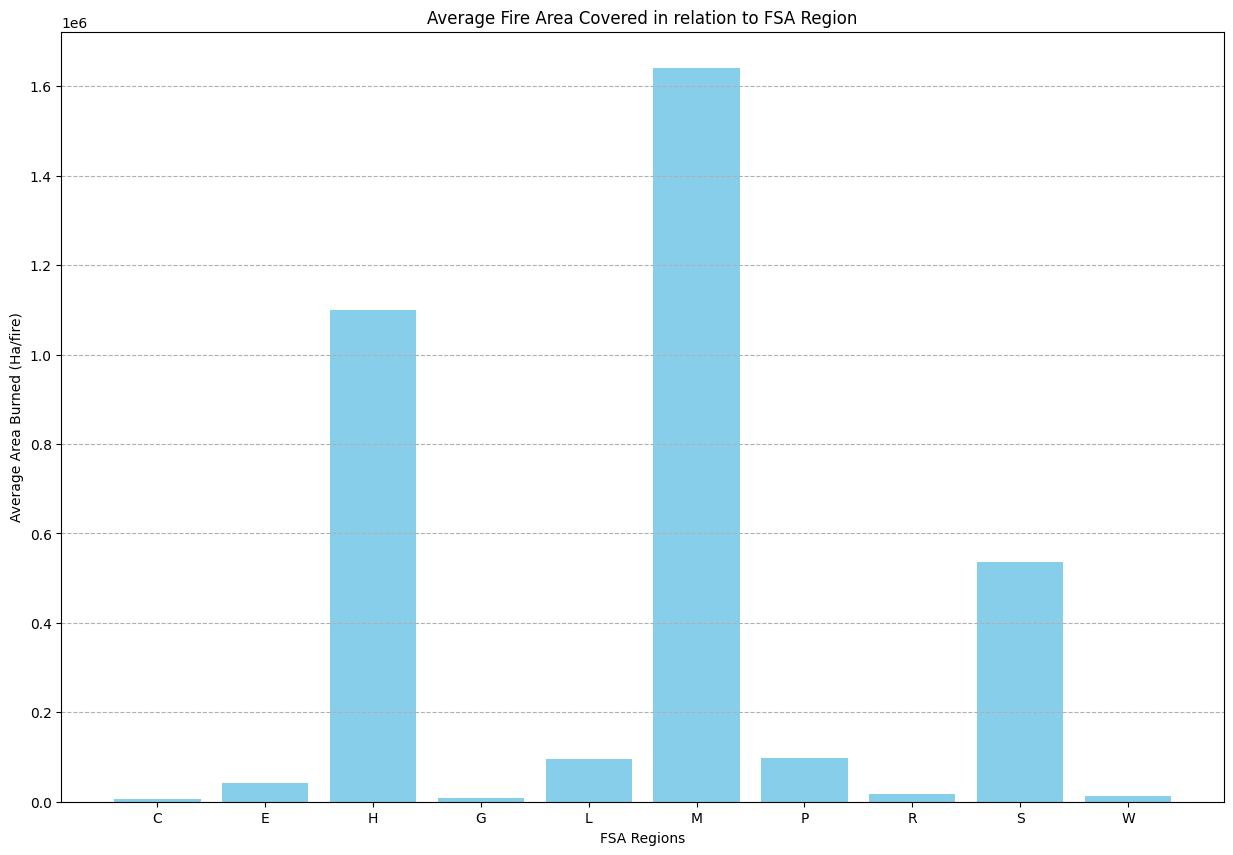

In [131]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

fig, ax = plt.subplots(figsize=(15, 10))
ax.yaxis.grid(True, linestyle='--')

ax.bar(categories, values, color='skyblue')
ax.set_title('Average Fire Area Covered in relation to FSA Region')
ax.set_xlabel('FSA Regions')
ax.set_ylabel('Average Area Burned (Ha/fire)')
plt.show()


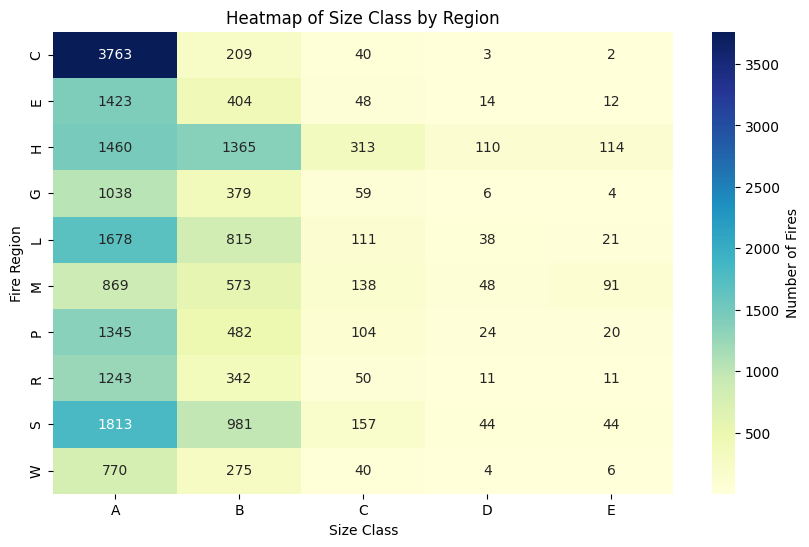

In [133]:
df_heatmap = pd.DataFrame(FSA_dict).T
df_heatmap.columns = ['Total', 'Size Class Count']

# Extracting Size Class information
size_class = df_heatmap.columns

df_heatmap = df_heatmap['Size Class Count'].apply(pd.Series)

# Count of Size Classes
count_size_classes = len(df_heatmap.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Fires'})
plt.title('Heatmap of Size Class by Region')
plt.xlabel('Size Class')
plt.ylabel('Fire Region')
plt.show()

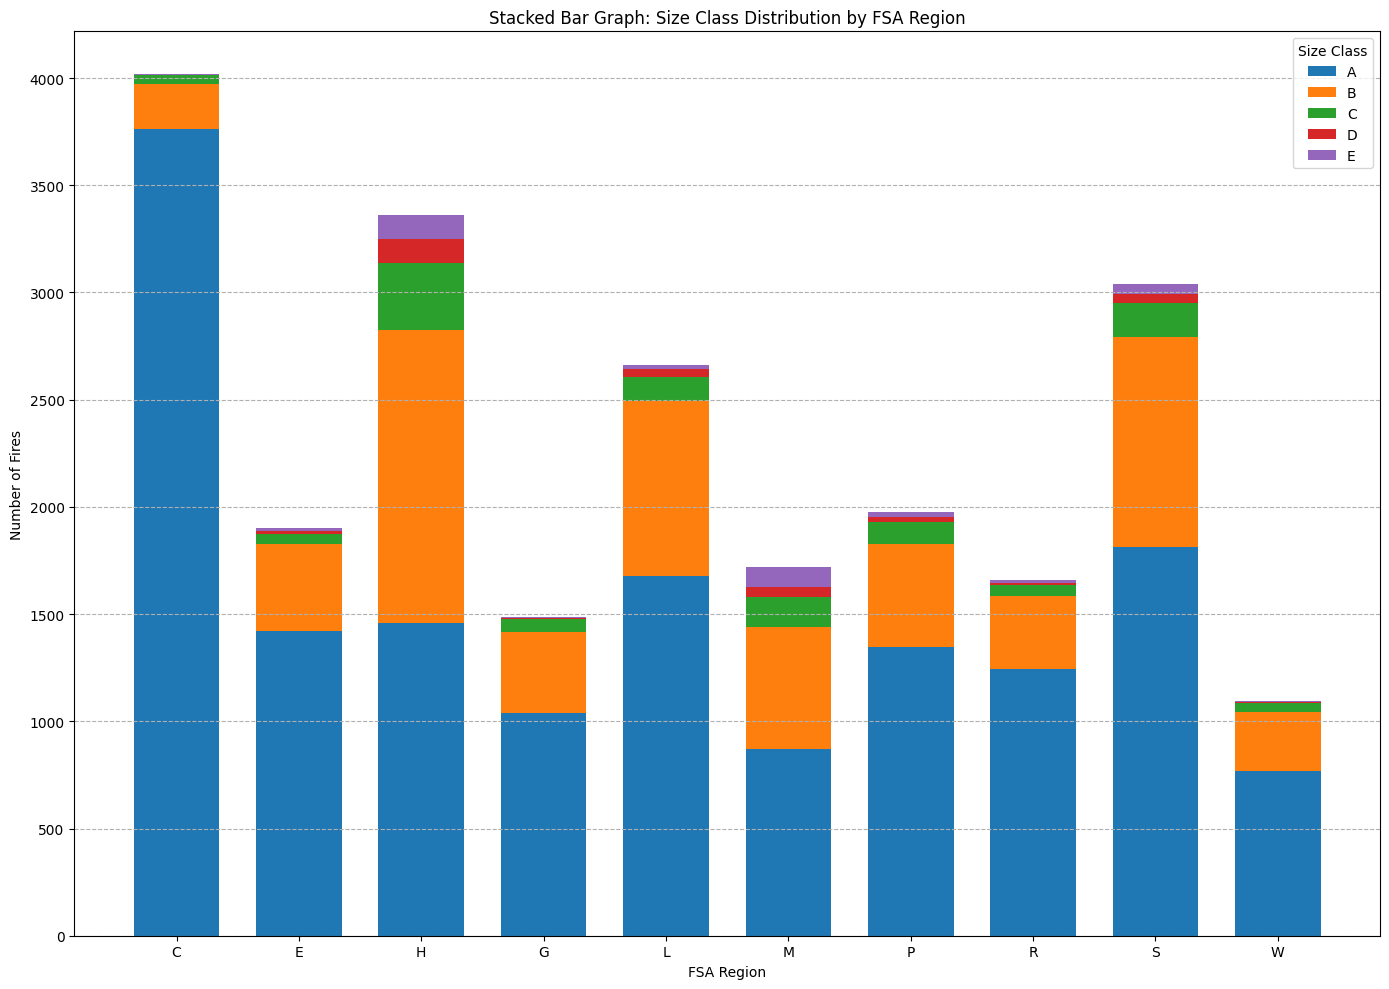

In [136]:
labels = list(FSA_dict.keys())
classes = list(FSA_dict[labels[0]][1].keys())
data = [[FSA_dict[fsa][1][cls] for fsa in labels] for cls in classes]

fig, ax = plt.subplots(figsize=(14, 10))
width = 0.7  # Increase the width for better visibility
ind = np.arange(len(labels))
bottom = np.zeros(len(labels))

# Use color map for better distinguishability
colors = plt.cm.tab10.colors

for i, cls in enumerate(classes):
    ax.bar(ind, data[i], width, bottom=bottom, label=cls, color=colors[i])
    bottom += np.array(data[i])

ax.set_ylabel('Number of Fires')
ax.set_xlabel('FSA Region')
ax.set_title('Stacked Bar Graph: Size Class Distribution by FSA Region')
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation=0)  # Rotate x-axis labels for better readability
ax.legend(title='Size Class', bbox_to_anchor=(1, 1))  # Move legend outside the plot for clarity
ax.yaxis.grid(True, linestyle='--')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [47]:
f_origin_list = {}
count = 0
rest_list = {}

for index in df.index:
    origin = df.loc[index, 'fire_origin']
    size_class = str(df.loc[index, 'size_class'])

    if origin not in f_origin_list:
        f_origin_list[origin] = [{'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}]

    f_origin_list[origin][0][size_class] += 1

print(f_origin_list)

indian_reservation_data = {'Indian Reservation': f_origin_list['Indian Reservation']}
other_data = {}

for key, value in f_origin_list.items():
    if key != 'Indian Reservation':
        if not other_data:
            other_data = {k: v for k, v in value[0].items()}
        else:
            for k, v in value[0].items():
                other_data[k] += v

print(indian_reservation_data)

print(other_data)

{'Provincial Land': [{'A': 11317, 'B': 3750, 'C': 736, 'D': 240, 'E': 302}], 'Indian Reservation': [{'A': 1646, 'B': 1091, 'C': 118, 'D': 21, 'E': 7}], 'Private Land': [{'A': 2123, 'B': 863, 'C': 174, 'D': 31, 'E': 6}], 'Provincial Park': [{'A': 184, 'B': 33, 'C': 13, 'D': 4, 'E': 8}], 'Metis Settlement': [{'A': 88, 'B': 42, 'C': 8, 'D': 1, 'E': 0}], 'DND': [{'A': 37, 'B': 44, 'C': 10, 'D': 4, 'E': 2}], 'National Park': [{'A': 1, 'B': 0, 'C': 0, 'D': 1, 'E': 0}], nan: [{'A': 6, 'B': 2, 'C': 1, 'D': 0, 'E': 0}]}
{'Indian Reservation': [{'A': 1646, 'B': 1091, 'C': 118, 'D': 21, 'E': 7}]}
{'A': 13756, 'B': 4734, 'C': 942, 'D': 281, 'E': 318}


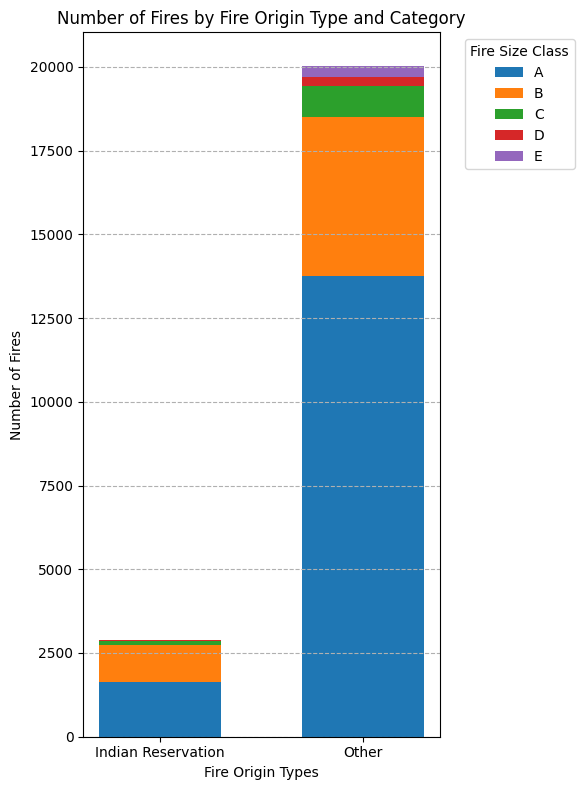

In [139]:
categories = list(other_data.keys())
origin_labels = list(indian_reservation_data.keys()) + ['Other']

fig, ax = plt.subplots(figsize=(6, 8))
bar_width = 0.6

bottom_values = [0] * len(origin_labels)

for category in categories:
    values = [indian_reservation_data[label][0][category] if label in indian_reservation_data else other_data[category] for label in origin_labels]
    ax.bar(origin_labels, values, width=bar_width, label=category, bottom=bottom_values)
    bottom_values = [bottom + value for bottom, value in zip(bottom_values, values)]

ax.set_ylabel('Number of Fires')
ax.set_xlabel('Fire Origin Types')
ax.set_title('Number of Fires by Fire Origin Type and Category')
ax.legend(title='Fire Size Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.grid(True, linestyle='--')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [90]:
stat_can_data = {'C': [1277415,41355], 'E': [7265,865], 'H': [2300,1250], 'G': [14745,9425], 'L': [5650,1915], 'M': [20,310], 'P': [5265,1200], 'R': [44971,2005], 'S': [4880,1780], 'W': [8595,1260]}
final_pop = {'C': [0, 0], 'E': [0, 0], 'H': [0, 0], 'G': [0, 0], 'L': [0, 0], 'M': [0, 0], 'P': [0, 0], 'R': [0, 0], 'S': [0, 0], 'W': [0, 0]}

weighted_indian = {'C': [0, 0, 0, 0], 
                   'E': [0, 0, 0, 0], 
                   'H': [0, 0, 0, 0], 
                   'G': [0, 0, 0, 0], 
                   'L': [0, 0, 0, 0], 
                   'M': [0, 0, 0, 0], 
                   'P': [0, 0, 0, 0],
                   'R': [0, 0, 0, 0], 
                   'S': [0, 0, 0, 0], 
                   'W': [0, 0, 0, 0]}

for key,value in stat_can_data.items():
    stat_can_data[key].append(stat_can_data[key][0]/stat_can_data[key][1])

for index in df.index:
    region = df.loc[index, 'fire_number']
    region = region[:1]
    if(df.loc[index, 'fire_origin'] == 'Indian Reservation'):
        weighted_indian[region][1] +=  df.loc[index, 'current_size']/stat_can_data[region][1]
        weighted_indian[region][3] += 1
    
    else:
        weighted_indian[region][0] +=  df.loc[index, 'current_size']/stat_can_data[region][0]
        weighted_indian[region][2] += 1

for key,value in weighted_indian.items():
    weighted_indian[key][0] = weighted_indian[key][0]/weighted_indian[key][2]
    try:
        weighted_indian[key][1] = weighted_indian[key][1]/weighted_indian[key][3]
    except(ZeroDivisionError):
       weighted_indian[key][1] = 0 

for key,value in weighted_indian.items():
    final_pop[key][0] = 1
    final_pop[key][1] = (weighted_indian[key][1]/weighted_indian[key][0])

print(final_pop)
print(weighted_indian)

{'C': [1, 21.56236840025146], 'E': [1, 0.0], 'H': [1, 0.009199758591531979], 'G': [1, 0.2599740057159525], 'L': [1, 0.06142147039344621], 'M': [1, 0.03140103820977695], 'P': [1, 0.008565190739986316], 'R': [1, 1.1371394437115396], 'S': [1, 0.09444716960499969], 'W': [1, 0.023610385843911452]}
{'C': [1.006834633105065e-06, 2.1709739277143427e-05, 3666, 351], 'E': [0.003032916713882307, 0, 1901, 0], 'H': [0.2094478661502915, 0.0019268698060941843, 2279, 1083], 'G': [0.0003463636413114568, 9.004554326610281e-05, 1433, 53], 'L': [0.009031624990957337, 0.000554735686986795, 1835, 828], 'M': [47.97274147058752, 1.5063938879456702, 1700, 19], 'P': [0.009692588343299512, 8.301886792452829e-05, 1922, 53], 'R': [0.00026438749167755396, 0.000300645445210503, 1521, 136], 'S': [0.040687868271781065, 0.0038428539955307917, 2682, 357], 'W': [0.001344579116830413, 3.1746031746031745e-05, 1092, 3]}


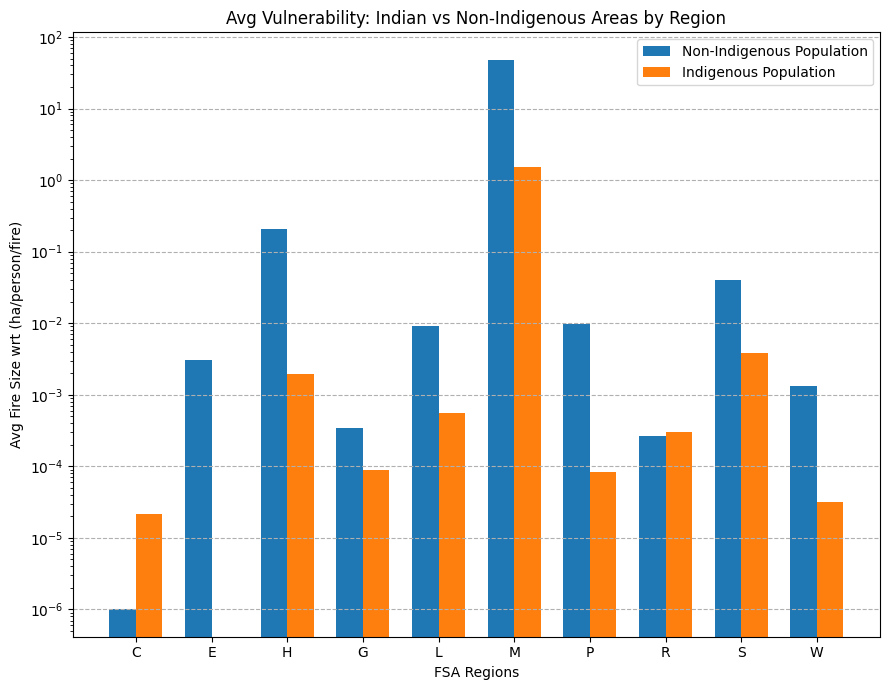

In [151]:
categories = list(weighted_indian.keys())
values1 = [item[0] for item in weighted_indian.values()]
values2 = [item[1] for item in weighted_indian.values()]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize = (9,7))

bar1 = ax.bar(index, values1, bar_width, label='Non-Indigenous Population')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Indigenous Population')

ax.set_xlabel('FSA Regions')
ax.set_ylabel('Avg Fire Size wrt (ha/person/fire)')
ax.set_title('Avg Vulnerability: Indian vs Non-Indigenous Areas by Region')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()
ax.set_yscale('log')
ax.yaxis.grid(True, linestyle='--')

plt.tight_layout()
plt.show()